# THz integrated demultiplexer/filter based on ring resonator

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FTHzDemultiplexerFilter.ipynb).

Note: the cost of running the entire notebook is larger than 1 FlexUnit.

Wireless communication technology has been experiencing rapid development to satisfy the ever growing need for higher data transmission speed. The current 5G network has been harnessing the power of microwave and mm wave. The future generations of wireless communication clearly points to even higher frequencies, entering the THz territory. 

Inspired by the advancement of integrated photonics at telecom wavelength, integrated THz technology is a promising candidate for future mass production of compact THz communication devices. This model aims to demonstrate the modeling of a silicon-based THz demultiplexer/filter, which is a crucial component in a high-speed integrated THz communication system. The device utilizes a ring resonator structure similar to a typical ring resonator used in a telecom integrated circuit. It achieves <1.5 dB transmission loss and 3 GHz free spectral range. The design of the device is adapted from [Deng, W. et al. On‐Chip Polarization‐ and Frequency‐Division Demultiplexing for Multidimensional Terahertz Communication. Laser Photon. Rev. 16, 2200136 (2022)](https://onlinelibrary.wiley.com/doi/abs/10.1002/lpor.202200136).

<img src="img/thz_ring_resonator.png" width="700">


## Simulation Setup 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import ModeSolver

[18:29:50] INFO     Using client version: 1.8.1                               ]8;id=131184;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=574157;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#112\112]8;;\

The demultiplexer/filter device consists of a ring resonator, a through port waveguide, and a drop port waveguide. It is fabricated on a silicon wafer with a thickness of 130 $\mu m$. A ridge waveguide with 110 $\mu m$ height is used. The radius of the ring resonator is designed to ensure low loss for the TE0 mode.   

In [2]:
t_si = 130  #thickness of the si wafer
t_wg = 110  #height of the ridge waveguide
W0 = 200   #width of the waveguide
R1 = 3500  #inner radius of the ring resonator
R2 = 2000  #inner radius of the waveguide bend
Wg = 50   #width of the gap
s = 3000  #horizontal shift of the waveguide bend
inf_eff = 1e5  #effective infinity. This parameter is used to ensure the ports extend into the pml.

freq0 = 380e9  #central frequency
lda0 = td.C_0/freq0  #central wavelength
freqs = np.linspace(375e9,385e9,301)   #wavelength range. 
#To ensure we resolve the spectral features, 301 frequency points are used.

Since the whole structure is made of silicon, only two materials need to be defined -- silicon and air. At the simulation frequency, silicon has a small loss of $\alpha$=0.025 $cm^{-1}$. Therefore, the imaginary part of the refractive index can be calculated as $k = \frac{\alpha \lambda}{4\pi}$. Since the frequency dispersion is very small, we will model silicon as dispersionless material.

In [3]:
alpha = 0.025  #loss
k_si = alpha*lda0*1e-4/(4*np.pi)  #imaginary part of the Si refractive index
n_si = 3.405  #real part of the Si refractive index

si = td.Medium.from_nk(n=n_si, k=k_si, freq=freq0)
air = td.Medium(permittivity = 1)

To build the device, we need to keep in mind that when two structures overlap, the one added later will override the one added earlier. This gives us great flexibility when making more complex geometries. 

To make the ring resonator, we first create a [Cylinder](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Cylinder.html?highlight=cylinder) made of silicon with the radius set to the outer radius of the ring. Then, another [Cylinder](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Cylinder.html?highlight=cylinder) made of air with the radius set to the inner radius of the ring is added. This effectively results in a silicon ring. The waveguide bend structure is built using the same principle. 

In [4]:
#through port waveguide
wg1 = td.Structure(geometry=td.Box.from_bounds(rmin=(-inf_eff,0,0), rmax=(inf_eff,W0,t_si)),
                   medium=si) 


#ring resonator
ring_out = td.Structure(geometry=td.Cylinder(center=(0, 2*W0+Wg+R1,t_si/2),radius=R1+W0,length=t_si,axis=2),
                       medium=si)

ring_in = td.Structure(geometry=td.Cylinder(center=(0, 2*W0+Wg+R1,t_si/2),radius=R1,length=t_si,axis=2),
                       medium=air)  


#waveguide bend
wg_bend_out = td.Structure(geometry=td.Cylinder(center=(-s, 4*W0+2*Wg+2*R1+R2,t_si/2),radius=R2+W0,length=t_si,axis=2),
                       medium=si)

wg_bend_in = td.Structure(geometry=td.Cylinder(center=(-s, 4*W0+2*Wg+2*R1+R2,t_si/2),radius=R2,length=t_si,axis=2),
                       medium=air)

wg_bend_left = td.Structure(geometry=td.Box.from_bounds(rmin=(-s,3*W0+2*Wg+2*R1,0), rmax=(-s+R2+W0,5*W0+2*Wg+2*R1*2*R2,t_si)),
                   medium=air)


#drop port waveguide
wg2 = td.Structure(geometry=td.Box.from_bounds(rmin=(-s,3*W0+2*Wg+2*R1,0), rmax=(s,4*W0+2*Wg+2*R1,t_si)),
                   medium=si)

wg3 = td.Structure(geometry=td.Box.from_bounds(rmin=(-s,4*W0+2*Wg+2*R1+2*R2,0), rmax=(inf_eff,5*W0+2*Wg+2*R1+2*R2,t_si)),
                   medium=si)


#si wafer 
si_substrate = td.Structure(geometry=td.Box.from_bounds(rmin=(-inf_eff,-inf_eff,0), rmax=(inf_eff,inf_eff,t_si-t_wg)),
                   medium=si)

Define source and monitors. Here we will define a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/search.html?q=modesource) that launches the TE0 mode into the input waveguide. Two [FluxMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FluxMonitor.html?highlight=fluxmonitor) are added to the through port and the drop port to monitor the transmission. A [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html?highlight=fieldmonitor) is added in the xy plane to visualize the field distribution.

In [5]:
mode_spec = td.ModeSpec(num_modes=1, target_neff=3)  #we are only interested in the TE0 mode so num_modes is set to 1
#add a mode source at the input of the waveguide
mode_source = td.ModeSource(
    center=(-1.5*R1, W0/2, t_si/2),
    size=(0, 4*W0, 4*t_si),
    source_time = td.GaussianPulse(
        freq0=freq0,
        fwidth=freq0/10),
    direction='+',
    mode_spec=mode_spec,
    mode_index=0)

#add two flux monitors at the through port and the drop port
flux_monitor1 = td.FluxMonitor(
    center = (1.5*R1,W0/2,t_si/2),
    size = (0, 4*W0, 4*t_si),
    freqs = freqs,
    name='flux1')  

flux_monitor2 = td.FluxMonitor(
    center = (1.5*R1,4.5*W0+2*Wg+2*R1+2*R2,t_si/2),
    size = (0, 4*W0, 4*t_si),
    freqs = freqs,
    name='flux2') 

freq1 = 378.8e9  #frequency at which the power is transmitted to the through port
freq2 = 380.2e9  #frequency at which the power is transmitted to the drop port

#define a field monitor in the z=0 plane to visualize the field flow
field_monitor = td.FieldMonitor(
    center = (0,0,t_si/2),
    size = (td.inf, td.inf, 0),
    freqs = [freq1, freq2],
    name='field'
)

Define the simulation using the above structures, source, and monitors. Due to the high-Q resonance of the ring resonator, we need to ensure that the simulation run time is sufficiently long.

<AxesSubplot: title={'center': 'cross section at z=130.00'}, xlabel='x', ylabel='y'>

<Figure size 432x288 with 1 Axes>

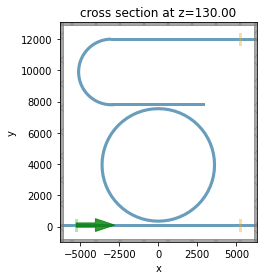

In [6]:
buffer_y = lda0  #buffer spacing in the y direction

#simulation domain size
Lx = 3.5*R1
Ly = 2*R1 + 2*R2 + 5*W0 + 2*Wg + 2*buffer_y
Lz = 1.5*lda0
sim_size = (Lx, Ly, Lz)

run_time = 12e-9  #simulation run time

#initialize the Simulation object
sim = td.Simulation(
        center=(0,Ly/2-buffer_y,t_si),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
        structures=[wg1, ring_out, ring_in, wg_bend_out, wg_bend_in, wg_bend_left, wg2, wg3, si_substrate],
        sources=[mode_source],
        monitors=[field_monitor,flux_monitor1,flux_monitor2],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
        )  

#visualize the structure to make sure it is set up correctly
sim.plot(z=t_si)

Visualize the mode field to ensure we are launching the TE0 mode at the mode source.

<Figure size 720x216 with 6 Axes>

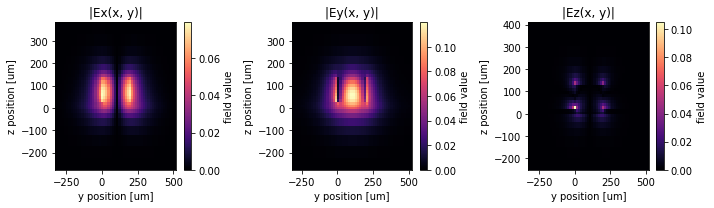

In [7]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=(-R1, W0/2, t_si/2), size=(0, 4*W0, 4*t_si)),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x='y', y='z', ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x='y', y='z', ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x='y', y='z', ax=ax3, cmap='magma')

ax1.set_title('|Ex(x, y)|')
ax2.set_title('|Ey(x, y)|')
ax3.set_title('|Ez(x, y)|')
plt.show()

Submit the simulation job to the server.

In [8]:
job = web.Job(simulation=sim, task_name='thz_demultiplexer')
sim_data = job.run(path='data/simulation_data.hdf5')

[18:29:52] INFO     Using Tidy3D credentials from stored file.                     ]8;id=192904;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=404944;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#70\70]8;;\

[18:29:53] INFO     Authentication successful.                                     ]8;id=840478;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=118409;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#30\30]8;;\

           INFO     Created task 'thz_demultiplexer' with task_id               ]8;id=35203;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=498248;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '514bbe6f-8ad4-4bf4-9c0c-ab815ea541d7'.                                  

Output()

[18:29:54] INFO     Maximum FlexUnit cost: 6.783                                ]8;id=338571;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=721902;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                             ]8;id=467184;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=738718;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#261\261]8;;\

Output()

[18:29:58] INFO     status = preprocess                                         ]8;id=210652;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=607267;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#273\273]8;;\

[18:30:07] INFO     starting up solver                                          ]8;id=510552;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=54597;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#277\277]8;;\

[18:30:18] INFO     running solver                                              ]8;id=73944;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=510835;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#283\283]8;;\

Output()

[18:35:26] INFO     early shutoff detected, exiting.                            ]8;id=104466;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=104601;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                        ]8;id=348055;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=175602;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#300\300]8;;\

Output()

[18:35:33] INFO     status = success                                            ]8;id=902725;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=265796;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 5.762                                 ]8;id=641737;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=683125;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=504607;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=884319;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#592\592]8;;\
                    "data/simulation_data.hdf5"                                              

Output()

[18:35:35] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=279937;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=940606;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#414\414]8;;\

## Result Visualization

At 378.8 GHz, the power is transmitted to the through port.

<AxesSubplot: title={'center': 'cross section at z=65.00'}, xlabel='x', ylabel='y'>

<Figure size 432x288 with 2 Axes>

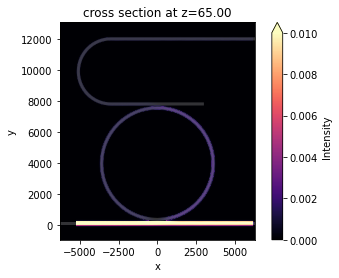

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
sim_data.plot_field('field', 'int', ax = ax, f=freq1, vmin=0, vmax=0.01)

At 380.2 GHz, the power is transmitted to the drop port.

<AxesSubplot: title={'center': 'cross section at z=65.00'}, xlabel='x', ylabel='y'>

<Figure size 432x288 with 2 Axes>

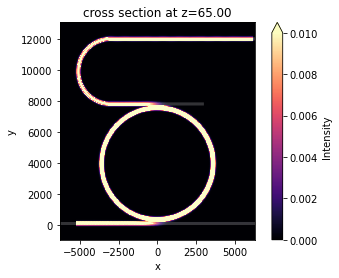

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
sim_data.plot_field('field', 'int', ax = ax, f=freq2, vmin=0, vmax=0.01)

Plot the transmission spectra at the through port and the drop port. A sub 1.5 dB transmission loss as well as a ~3 GHz free spectral range is observed.

<matplotlib.legend.Legend object at 0x7fcd610d73a0>

<Figure size 432x288 with 1 Axes>

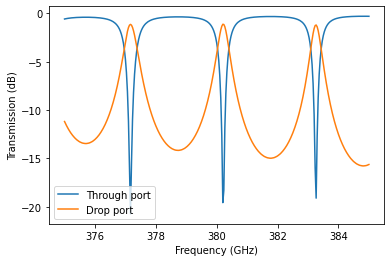

In [11]:
T1 = sim_data['flux1'].flux
T2 = sim_data['flux2'].flux

plt.plot(freqs/1e9, 10*np.log10(T1), freqs/1e9, 10*np.log10(T2))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission (dB)')
plt.legend(('Through port', 'Drop port'))